# Chladni Modes and Laplacian Spectrum

In [1]:
%matplotlib inline
#
from lrgsglib.core import *
#
move_to_rootf()
plt.style.use('ipynb/nb_plotsheet.mplstyle')
#
path_chladni = PATHDATA / 'chladni'
path_cluster_chladni = PATHDATA / 'cluster_data' / 'chladni'
path_plotchladni = PATHPLOT / 'chladni'

Current working directory: /home/opisthofulax/Documents/PhD/projects/complex-networks/lrgsglib


### Energy plots

In [34]:
geo = 'tri'
side_list = [32, 64, 128]

In [35]:
l = {}
test_ene = {}
for side in side_list:
    fname = f'Lattice2D{geo}_wspect_{side}.pkl'
    pname = path_chladni / f'Lattice2D{geo}_wspect_{side}.pkl'
    if os.path.exists(pname):
        l[side] = pk.load(open(pname, 'rb'))
    else:
        l[side] = Lattice2D(side, geo=geo)
        l[side].compute_k_eigvV(with_routine='numpy')
        for _ in range(l[side].N):
            l[side].compute_rbim_energy_eigV(_)
        with open(pname, 'wb') as f:
            pk.dump(l[side], f)
    test_ene[side] = [l[side].get_rbim_energy_eigV(_)/(2*l[side].N) 
                      for _ in range(l[side].N)]

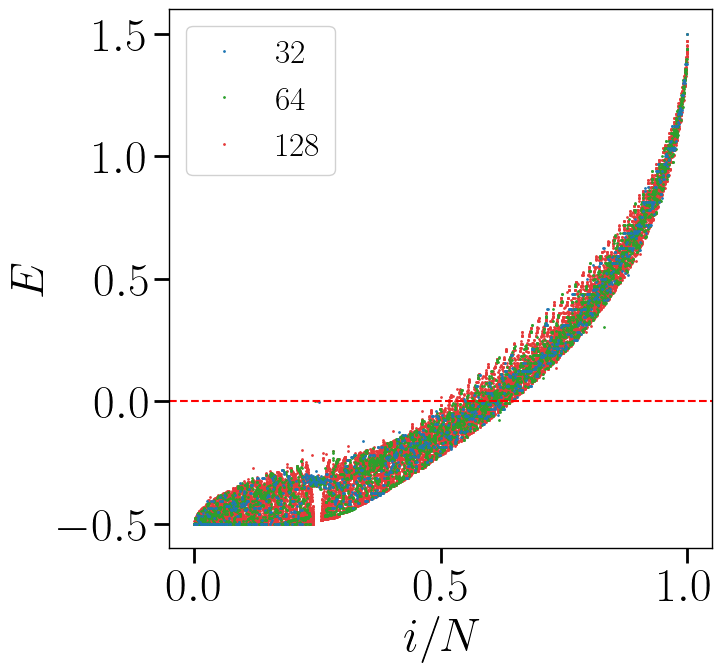

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
for side in side_list:
    eignum = np.linspace(0, 1, num=len(test_ene[side]))
    ax.plot(eignum, -np.array(test_ene[side])[::-1], 
            'o', ms=1, label=f'{side}', zorder=1/side)
ax.axhline(0, ls='--', color='r')
ax.set_ylabel(r'$E$')
ax.set_xlabel(r'$i/N$')
ax.legend(fontsize=24)

fig.savefig(path_plotchladni / f'chladni_{geo}_ene.pdf', bbox_inches='tight', transparent=True)
plt.close('all')

### Antiferro Reconstruction

In [8]:
side = 32
geo = 'tri'
pflip = 1
kwargs_TriL2D = dict(side1=side, geo=geo, pflip=pflip, with_positions=True)
#
T = 1
ic = 'uniform'
runlang = 'C3'
thrmSTEP = 1
eqSTEP = 1
freq = 20
kwargs_ISDY = dict(T=T, ic=ic, runlang=runlang, thrmSTEP=thrmSTEP, 
                   eqSTEP=eqSTEP, freq=freq)
#
remove_files = True

In [9]:
TriL2D = Lattice2D(**kwargs_TriL2D)
TriL2D.flip_random_fract_edges()
TriL2D.compute_k_eigvV(with_routine='numpy')

In [101]:
isdy = IsingDynamics(TriL2D, **kwargs_ISDY)
isdy.init_ising_dynamics()
isdy.run()
if remove_files:
    isdy.remove_run_c_files(remove_stderr=True)
    TriL2D.remove_exported_files()

In [ ]:
spin_arr = isdy.s
spin0_arr = isdy.s_0
spin_arr2d = spin_arr.reshape(*TriL2D.syshape)
basis = np.array([TriL2D.get_eigV_check(i, reshaped=True) for i in range(TriL2D.N//2)])
projection = np.array(matrix_projection(spin_arr2d, basis))
recon = np.sign(reconstruct_from_projections(projection, basis))
spin_overlap(spin_arr2d, recon), spin_overlap(spin_arr2d, recon)

(0.994140625, 0.994140625)

In [10]:
graph = TriL2D.G
pos = TriL2D.get_node_attributes('pos')
points = np.array(list(pos.values()))
x, y = points.T

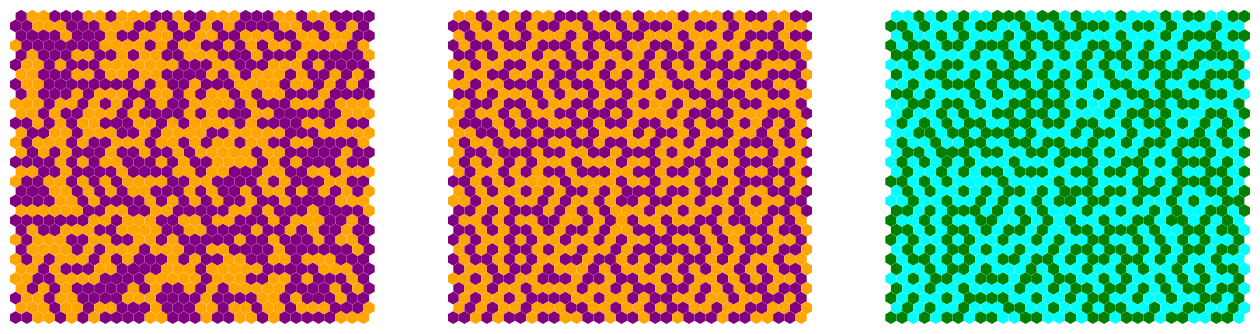

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 12))

cmap = ListedColormap(['purple', 'orange'])
cmap2 = ListedColormap(['green', 'cyan'])
plot_hex_tiling_from_nodes(x, y, spin0_arr, ax=ax[0], cmap=cmap)
plot_hex_tiling_from_nodes(x, y, spin_arr, ax=ax[1], cmap=cmap)
plot_hex_tiling_from_nodes(x, y, recon.flatten(), ax=ax[2], cmap=cmap2)

for axx in ax:
    axx.set_aspect('equal')
    axx.axis('off')

fig.savefig(path_plotchladni / f'chladni_{geo}_spin.pdf', bbox_inches='tight', transparent=True)
plt.close('all')

### Antiferro reconstruction part 2
We have to show that starting from states with high energy $i\in[N/2, N]$ the overlap jumps higher than $50\%$ withing the first hundreds of eigenmodes, while for random states it takes another curve, do the variance.
- for the high energy eigenmodes choose 3 values 
- for the random shows different temperaturesa

In [23]:
side = 16
geo = 'tri'
pflip = 1
kwargs_TriL2D = dict(side1=side, geo=geo, pflip=pflip, with_positions=True,
                     path_data=path_plotchladni)
#

In [24]:
ltmp = Lattice2D(**kwargs_TriL2D)
ltmp.flip_random_fract_edges()
ltmp.compute_k_eigvV(with_routine='numpy')

In [25]:
T = 0
ic_list = [f"gs_{ltmp.N//3+i-1}" for i in range(0, 2*ltmp.N//3+1, ltmp.N//6)]
runlang = 'C3'
thrmSTEP = 1
eqSTEP = 1
freq = 5
#
remove_files = True

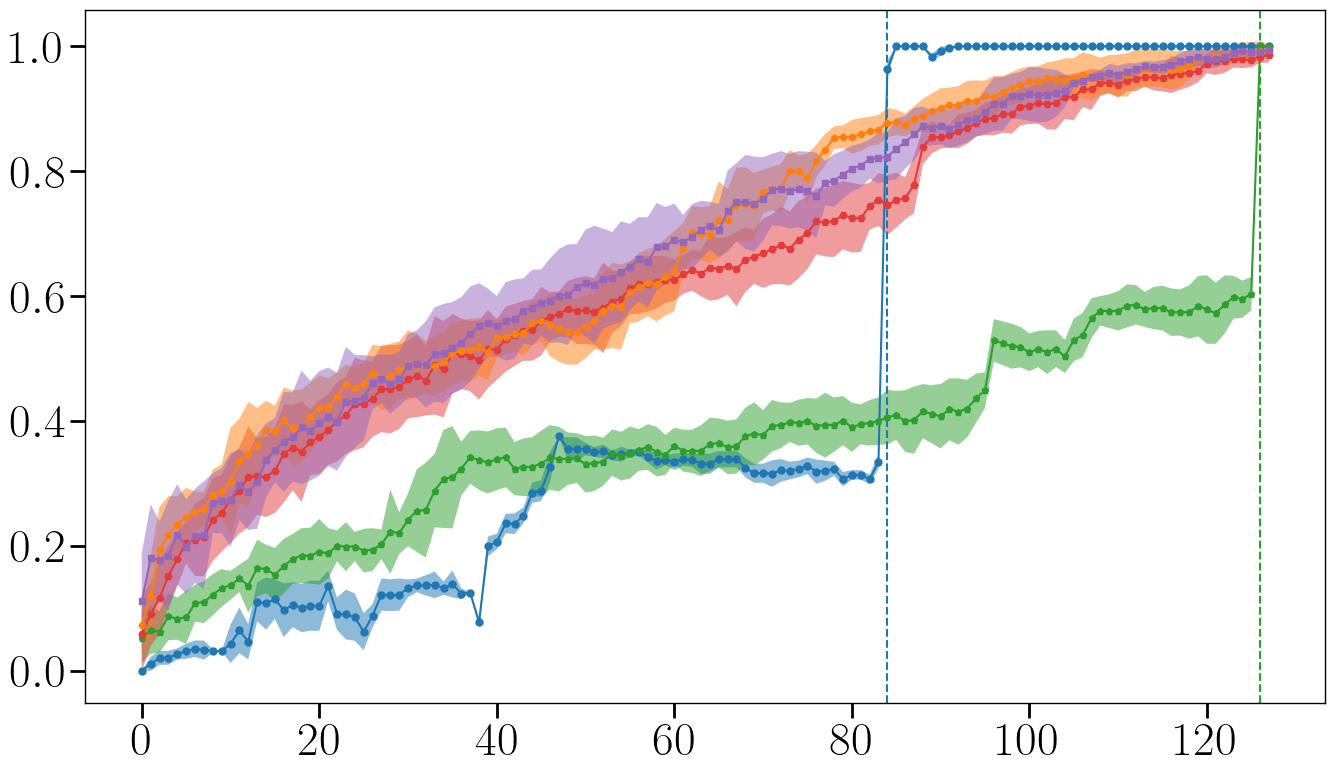

In [32]:
for icc in ic_list:
    path_fname = ltmp.path_lrgsg / f'spinovp_{icc}_avg_std_{side}_{geo}_T{T}.pkl'
    data = pk.load(open(path_fname, 'rb'))
    line, = plt.plot(data[0])
    plt.fill_between(np.arange(len(data[0])), data[0]-data[1], data[0]+data[1], alpha=0.5)
    idx = int(icc.split('_')[-1])
    if idx < ltmp.N//2:
        plt.axvline(idx, c=line.get_color(), ls='--')

In [28]:
idx

'252'

In [18]:
sout_dict = {}
for icc in ic_list:
    kwargs_ISDY = dict(T=T, ic=icc, runlang=runlang, thrmSTEP=thrmSTEP, 
                   eqSTEP=eqSTEP, freq=freq, out_suffix=icc)
    isdy = IsingDynamics(ltmp, **kwargs_ISDY)
    isdy.init_ising_dynamics()
    isdy.run()
    if remove_files:
        isdy.remove_run_c_files(remove_stderr=True)
        ltmp.remove_exported_files()
    sout_dict[icc] = {'s_0': isdy.s_0, 's_f': isdy.s}

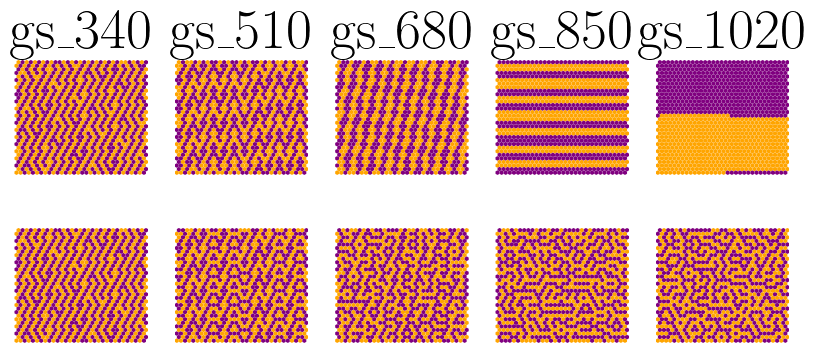

In [19]:
figscale = 2
fig, ax = plt.subplots(ncols=len(sout_dict), nrows=2, figsize=(figscale*len(sout_dict), figscale*2))
ax = ax.flatten()

for i, icc in enumerate(ic_list):
    ax[i].set_title(icc)
    spin0_arr = sout_dict[icc]['s_0'].reshape(*ltmp.syshape)
    spin_arr = sout_dict[icc]['s_f'].reshape(*ltmp.syshape)
    #
    cmap = ListedColormap(['purple', 'orange'])
    plot_hex_tiling_from_pos(ltmp.get_node_attributes('pos'), spin0_arr.flatten(), ax=ax[i], cmap=cmap)
    plot_hex_tiling_from_pos(ltmp.get_node_attributes('pos'), spin_arr.flatten(), ax=ax[i+len(sout_dict)], cmap=cmap)
for axx in ax:
    axx.axis('off')
    axx.set_aspect('equal')

In [ ]:
spinovp = {}
basis = np.array([ltmp.get_eigV_check(i, reshaped=False)
                  for i in range(ltmp.N//2)])
for icc in ic_list:
    s_f_icc = sout_dict[icc]['s_f']
    spinovp[icc] = [spin_overlap(compute_recon(s_f_icc, basis[:i+1]), s_f_icc) 
                    for i in range(ltmp.N//2)]

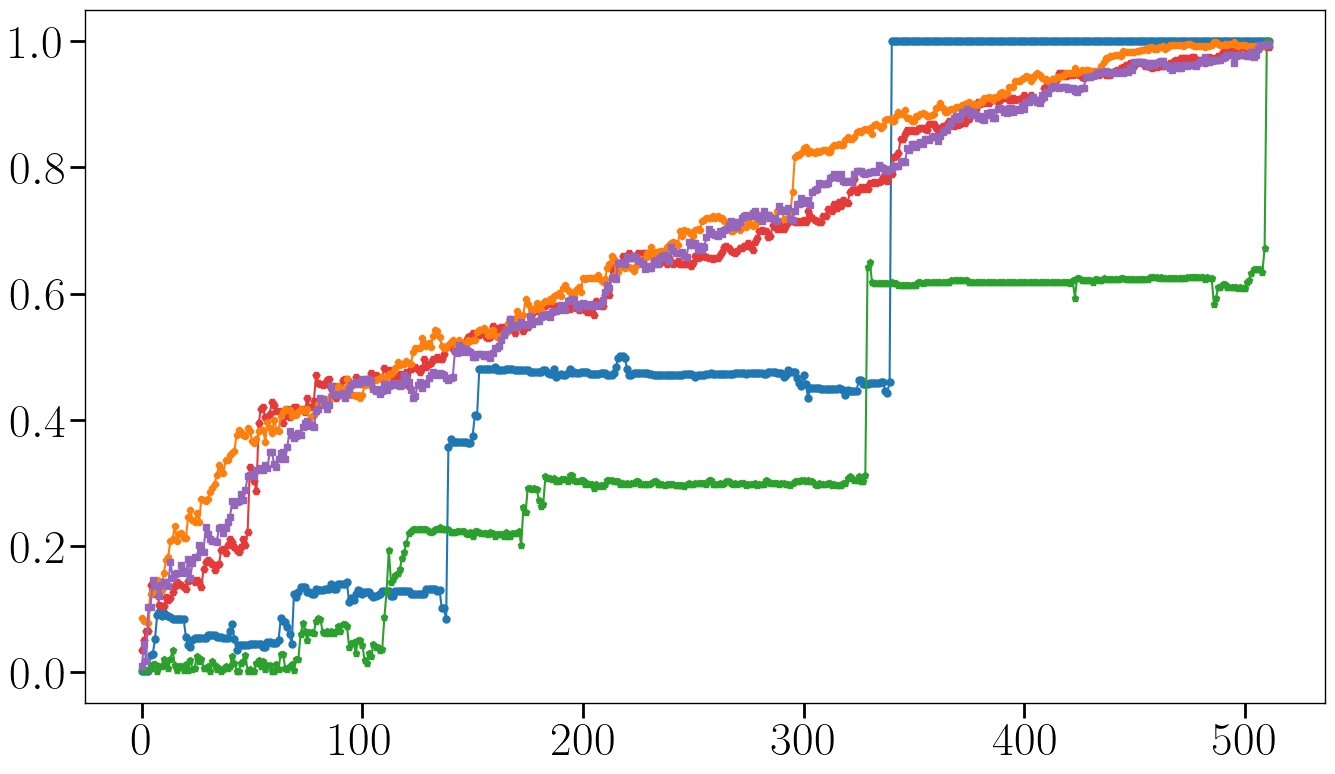

In [ ]:
for k in spinovp.keys():
    plt.plot(spinovp[k])

### Averaging Antiferro reconstruction

In [ ]:
p_overlap = {}
projections = {}
indices = {}
for j, s in enumerate(sout[:3]):
    p_overlap[j] = []
    projections[j] = []
    indices[j] = []
    for i in range(0, 2048, 32):
        basis = np.array([TriL2D.get_eigV_check(i, reshaped=True) for i in range(0, i+1)])
        projection = np.array(matrix_projection(s, basis))
        projections[j].append(projection)
        try:
            abs_proj = np.abs(projection)
            index = np.argpartition(abs_proj, -256)[-256:]
            indices[j].append(index[np.argsort(abs_proj[index])[::-1]])
        except ValueError:
            indices[j].append(np.array([np.argmax(projection)]))
        recon = np.sign(reconstruct_from_projections(projection, basis))
        p_overlap[j].append([i+1, spin_overlap(s, recon)])
    p_overlap[j] = np.array(p_overlap[j])

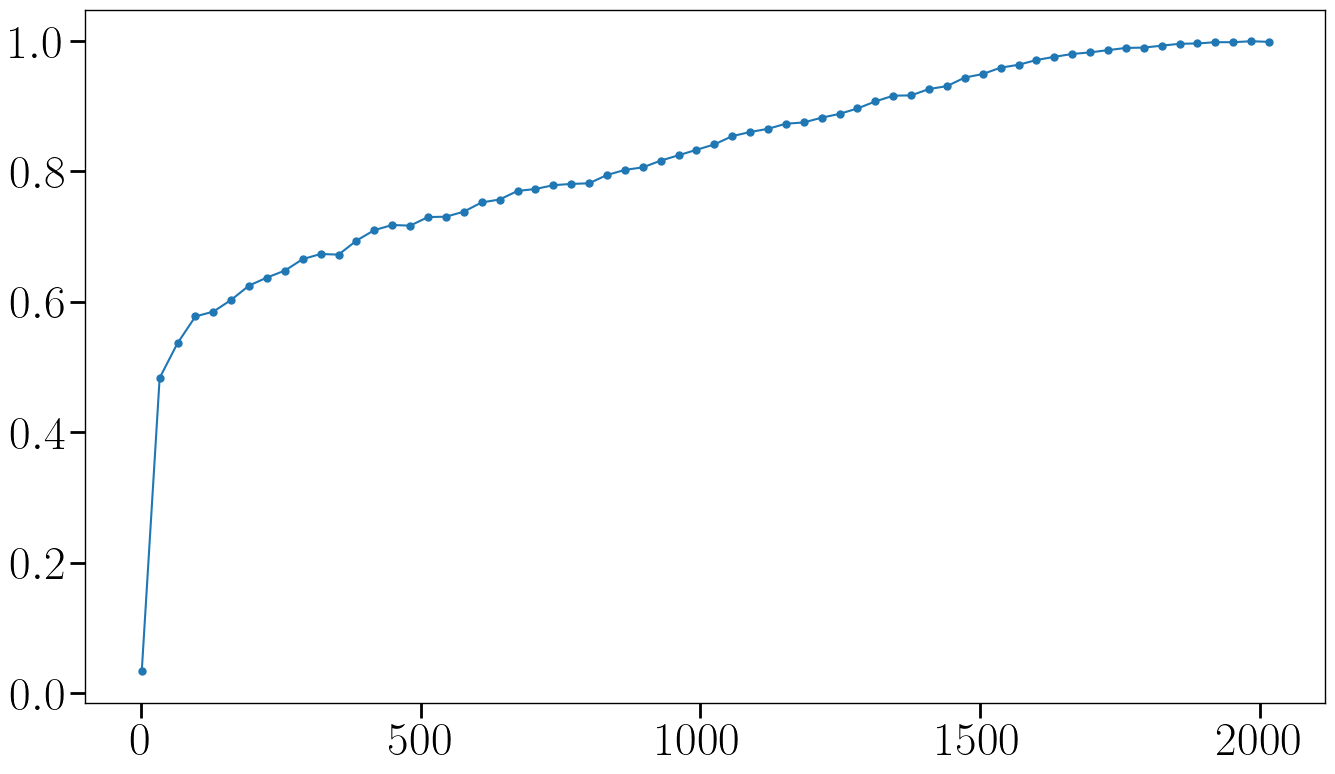

In [ ]:
plt.plot(p_overlap[2][:, 0], p_overlap[2][:, 1])

In [ ]:
matproj = isdy.s.reshape(*TriL2D.syshape)
basis = np.array([TriL2D.eigV[i].reshape(*TriL2D.syshape) for i in indices[-1]])
projections = np.array(matrix_projection(matproj, basis))
recon = np.sign(reconstruct_from_projections(projections, basis))
p_overlap = spin_overlap(isdy.s.reshape(*TriL2D.syshape), recon)
print(p_overlap)

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions from 60 to 3 using PCA on the projection coefficients
pca = PCA(n_components=3)
proj_pca = pca.fit_transform(projections)

# Plot the 3D trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(proj_pca[:,0], proj_pca[:,1], proj_pca[:,2], '-o', markersize=2)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.title('Trajectory in PCA-reduced Eigenbasis')

plt.show()


In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[1].imshow(recon, origin='lower')
ax[0].imshow(isdy.s.reshape(*TriL2D.syshape), origin='lower')


In [ ]:

plt.imshow(basis.T, aspect='auto', interpolation='none')
plt.xlabel('Time step')
plt.ylabel('Eigenmode index')
plt.colorbar(label='Coefficient value')
plt.show()

In [ ]:
X = np.linspace(0, 2048, 2048//128)
plt.plot(X/4096, p_overlap)
plt.plot(X/4096, 0.02*X**(1/1.999))

In [ ]:
# overlap = np.array([spin_overlap(isdy.s.reshape(*l.syshape),l.get_eigV_bin_check(i).reshape(*l.syshape)) for i in range(l.N)])
# sorted_args = np.argsort(overlap)[::-1]
matproj = isdy.s.reshape(*TriL2D.syshape)
basis = np.array([TriL2D.eigV[i].reshape(*TriL2D.syshape) for i in range(0, 1024)])
projections = np.array(matrix_projection(matproj, basis))

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
recon = np.sign(reconstruct_from_projections(projections, basis))
ax[1].imshow(recon, origin='lower')
ax[0].imshow(isdy.s.reshape(*TriL2D.syshape), origin='lower')
p_overlap = spin_overlap(isdy.s.reshape(*TriL2D.syshape), recon)
print(p_overlap)

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i in range(3):
    ax[i].imshow(-l.get_eigV_bin_check(sorted_args[i]).reshape(*l.syshape), origin='lower')
    ax[i].axis('off')
    ax[i].set_title(f'{sorted_args[i]}')
ax[3].imshow(isdy.s.reshape(*l.syshape), origin='lower')
ax[3].axis('off')
ax[4].imshow(np.sign(reconstruct_from_projections(projections, basis)), origin='lower')
ax[4].axis('off')

## SL

In [ ]:
lsl = Lattice2D(64, pflip=0.2, geo='sqr')
lsl.flip_random_fract_edges()

In [ ]:
lsl.compute_k_eigvV(with_routine='numpy')

In [ ]:
isdy = IsingDynamics(lsl, T=0.5, ic='uniform', runlang='C3', rndStr=True)

In [ ]:
isdy.init_ising_dynamics()
lsl.export_edgel_bin(exName=isdy.id_string_isingdyn)
isdy.export_ising_clust()
isdy.run(verbose=False, thrmSTEP=80)
if remove_files:
    isdy.remove_run_c_files(remove_stderr=True)
    lsl.remove_edgl_file()

In [ ]:
matproj = isdy.s.reshape(*lsl.syshape)
basis = np.array([lsl.eigV[i].reshape(*lsl.syshape) for i in range(256)])
projections = np.array(matrix_projection(matproj, basis))

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
recon = np.sign(reconstruct_from_projections(projections, basis))
ax[0].imshow(recon, origin='lower')
ax[1].imshow(isdy.s.reshape(*TriL2D.syshape), origin='lower')
p_overlap = spin_overlap(isdy.s.reshape(*TriL2D.syshape), recon)
print(p_overlap)

In [ ]:
ll = Lattice2D(64)
ll.compute_k_eigvV(with_routine='numpy')

In [ ]:
plt.imshow(np.abs(ll.eigV[0].reshape(*ll.syshape)), origin='lower')

## Trash

In [ ]:
T = 0.0
geo = 'sqr'
pflip = 0
remove_files = False

In [ ]:
l = Lattice2D(64, pflip=pflip, geo=geo)
l.flip_random_fract_edges()
l.compute_k_eigvV(with_routine='numpy')

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(10, 3.5))
count = 0
for i in range(3):
    for j in range(5):
        ax[i, j].imshow(l.get_eigV_bin_check(count).reshape(*l.syshape), origin='lower')
        ax[i, j].axis('off')
        ax[i, j].set_title(f'{count}')
        count += 1

In [ ]:
test_ene = [l.get_rbim_energy_eigV(_)/(2*l.N) for _ in range(l.N)]
plt.plot(test_ene, 'o', ms=0.5)

In [ ]:
isdy = IsingDynamics(l, T=T, ic='ground_state_0', runlang='C3', rndStr=True)
isdy.init_ising_dynamics()
l.export_edgel_bin(exName=isdy.id_string_isingdyn)
isdy.export_ising_clust()
isdy.run(verbose=False, thrmSTEP=200)
if remove_files:
    isdy.remove_run_c_files(remove_stderr=True)
    l.remove_edgl_file()

In [ ]:
4096*3000

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(l.get_eigV_bin_check(1023).reshape(*l.syshape))
ax[1].imshow(isdy.s.reshape(*l.syshape))

In [ ]:
np.exp(-1/0.1), 1/4096

In [ ]:
ene = np.fromfile(l.isingpath /Path('ene_p=0_T=0_.bin'), dtype=np.float64)

In [ ]:
l.get_rbim_energy_eigV(2048)/(2*l.N)

In [ ]:
plt.plot(ene/(4))
# plt.yscale('symlog')
plt.xscale('symlog')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(isdy.s.reshape(*l.syshape), origin='lower')
ax.axis('off')

In [ ]:
overlap = np.array([spin_overlap(isdy.s.reshape(*l.syshape),l.get_eigV_bin_check(i).reshape(*l.syshape)) for i in range(l.N)])
sorted_args = np.argsort(overlap)[::-1]
matproj = isdy.s.reshape(*l.syshape)
basis = np.array([l.eigV[i].reshape(*l.syshape) for i in sorted_args[:500]])
projections = np.array(matrix_projection(matproj, basis))

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i in range(3):
    ax[i].imshow(-l.get_eigV_bin_check(sorted_args[i]).reshape(*l.syshape), origin='lower')
    ax[i].axis('off')
    ax[i].set_title(f'{sorted_args[i]}')
ax[3].imshow(isdy.s.reshape(*l.syshape), origin='lower')
ax[3].axis('off')
ax[4].imshow(np.sign(reconstruct_from_projections(projections, basis)), origin='lower')
ax[4].axis('off')

In [ ]:
spin_overlap(isdy.s.reshape(*l.syshape), np.sign(reconstruct_from_projections(projections, basis)))